### Process ASTADs

In [1]:
import sys
sys.path.append("..")
from utilities import defaultPlotting, processBlacklist
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pybedtools import BedTool
from statsmodels.stats.multitest import fdrcorrection

In [2]:
def readCNV(cell):
    names = {'chrom': str, 'start': int, 'end': int, 'status': str}
    cnv = pd.read_csv(
        f'../0.processCNV/{cell}-CNV-UCSC.bed', 
        names=names.keys(), dtype=names,
        usecols=[0,1,2,3], skiprows=2, sep='\t')
    return cnv

In [3]:
def processCNVoverlap(cell, allTADs):
    cnv = readCNV(cell)
    # Retrieve CNV status for each TAD (a TAD may overlap multiple CNVs)
    allTADs_bed = BedTool.from_dataframe(allTADs[['chrom', 'start', 'end']])
    cnvOverlap = []
    for status, df in cnv.groupby('status'):
        bed = BedTool.from_dataframe(df).merge()
        overlap = allTADs_bed.intersect(bed, wo=True).to_dataframe()
        overlap['CNV'] = status
        cnvOverlap.append(overlap)
    # Sum total CNV overlap (if multiple CNVs overlap we will pick the largest overlap)
    cnvOverlap = pd.concat(cnvOverlap).rename({'thickStart': 'overlap'}, axis=1)
    cnvOverlap = cnvOverlap.groupby(['chrom', 'start', 'end', 'CNV'])['overlap'].sum().reset_index()

    # Retrieve TADs that ONLY overlap Normal CNV
    # A TAD is ONLY considered normal if ALL of it overlaps Normal CNV
    normalOnly = (
        cnvOverlap.groupby(['chrom', 'start', 'end'])['CNV']
        .apply(lambda x: x.unique()[0] == 'Normal').reset_index())
    normalOnly = normalOnly.rename({'CNV': 'Normal'}, axis=1)

    # Add Normal overlap to cnvData
    cnvOverlap = pd.merge(
        cnvOverlap, normalOnly, 
        left_on=['chrom', 'start', 'end'], right_on=['chrom', 'start', 'end'])

    # For non-Normal TADs remove records of Normal overlap
    # Because we want to find the biggest non-Normal overlapped CNV
    cnvOverlap = cnvOverlap.loc[(cnvOverlap['Normal']) | (cnvOverlap['CNV'] != 'Normal')]

    # Sort by overlap and drop duplicate intervals, i.e. get CNV status with largest overlap per TAD
    cnvOverlap = cnvOverlap.sort_values('overlap', ascending=False).drop_duplicates(['chrom', 'start', 'end'])
    
    return cnvOverlap.drop(['overlap', 'Normal'], axis=1)

In [5]:
name = 'ASTAD'
autosomes = [f'chr{chrom}' for chrom in range(1, 22+1)]

cols = ['chrom', 'start', 'end', 'type', 'z', 'direction', 'CNV']
USCSCcols = ['chrom', 'start', 'end', 'type', 'score', 'strand', 'start', 'end', 'colour']
excelCols = ['cell', 'chrom', 'start', 'end', 'type', 'z', 'CNV', 'High_Signal_Region', 'Low_Mappability']

In [6]:
threshold = 2

In [7]:
allData = []
cells = ['GM12878', 'IMR90', 'H1hESC']
with pd.ExcelWriter(f'allTADstats.xlsx') as writer:
    for cell in cells:
        allFiles = glob.glob(
            f'../../{cell}/alleleGRCh37/dat/tads/*/20000/{cell}_a1-vs-{cell}_a2-*-20000-adjIF1-SNPsplit.pkl')
        allTADs = pd.concat([pd.read_pickle(file) for file in allFiles]).reset_index(drop=True)

        # Compute autosomal mean and std
        autosomesMean = (
            allTADs[['chrom', 'size', 'mean', 'std']]
            .drop_duplicates()
            .groupby('size')[['mean', 'std']]
            .mean()
        )

        xOnly = allTADs.loc[~allTADs['chrom'].isin(autosomes)]

        # Update mean and std for X with autosomal values
        xOnly = pd.merge(xOnly.drop(['mean', 'std'], axis=1), autosomesMean, left_on='size', right_on='size')
        xOnly['z'] = (xOnly['sumDiff'] - xOnly['mean']) / xOnly['std']

        # Update full data with recomputed X chromosome
        allTADs = pd.concat([allTADs.loc[allTADs['chrom'].isin(autosomes)], xOnly]).reset_index(drop=True)
        
        # Add CNV information
        cnvOverlap = processCNVoverlap(cell, allTADs)
        allTADs = pd.merge(
            allTADs, cnvOverlap, 
            left_on=['chrom', 'start', 'end'], 
            right_on=['chrom', 'start', 'end'], how='left')
        allTADs['CNV'] = allTADs['CNV'].fillna('Unknown')
        
        allTADs = processBlacklist(allTADs)
        allTADs['High_Signal_Region'] = allTADs['High_Signal_Region'].fillna(0)
        allTADs['Low_Mappability'] = allTADs['Low_Mappability'].fillna(0)
        
        allTADs['rank'] = allTADs['z'].rank(pct=True)
        allTADs['score'] = allTADs['rank'] * 1000
        allTADs['diffTAD'] = allTADs['z'] > threshold
        allTADs['type'] = allTADs['diffTAD'].apply(lambda x: name if x else f'non-{name}')
        allTADs['cell'] = cell
        
        allTADs[excelCols].to_excel(writer, sheet_name=cell, index=False)
        allData.append(allTADs.copy())

        allTADs.to_pickle(f'{cell}-allTAD.pkl')
        
        allTADs['direction'] = '+'
        
        valid = (
            (allTADs['High_Signal_Region'] == 0) 
            & (allTADs['Low_Mappability'] == 0) 
            & (allTADs['CNV'] == 'Normal'))
        filtered = allTADs.loc[valid]
        # Write unmerged data with FDR and p values to BED format file
        filtered.sort_values(['chrom', 'start']).to_csv(f'{cell}-TADs-allTAD.bed', 
                    sep='\t', index=False, header=False, columns=cols)

        filtered.loc[allTADs['type']=='ASTAD'].sort_values(['chrom', 'start']).to_csv(f'{cell}-ASTADs-allTAD.bed', 
                    sep='\t', index=False, header=False, columns=cols)

        autosomeTADs = filtered.loc[filtered['chrom'].isin(autosomes)]
        autosomeTADs.sort_values(['chrom', 'start']).to_csv(f'{cell}-TADs-autosome.bed', 
                    sep='\t', index=False, header=False, columns=cols)

        (autosomeTADs.loc[(autosomeTADs['type']==name)]
         .sort_values(['chrom', 'start'])
         .to_csv(f'{cell}-ASTADs-autosome.bed', sep='\t', 
             index=False, header=False, columns=cols))

        allTADs['strand'] = '.'
        allTADs['colour'] = allTADs['diffTAD'].apply(lambda x: '253,192,134' if x else '211,211,211')
        with open(f'{cell}-allTAD-UCSC.bed', mode='w') as fh:
            print(f'track name="{cell}_TADs" '
                  f'description="{cell}: TADs by Allele Specificity, '
                  f'db=hg19 visibility=4 useScore="On"', file=fh)
            print('browser position chr14:97000000-103000000', file=fh)
            allTADs[USCSCcols].to_csv(fh, index=False, header=False, sep='\t')

        with open(f'{cell}-ASTADs-UCSC.bed', mode='w') as fh:
            print(f'track name="{cell}_ASTADs" '
                  f'description="{cell}: ASTADs by Allele Specificity" '
                  f'db=hg19 visibility=4 useScore="On"', file=fh)
            print('browser position chr14:97000000-103000000', file=fh)
            allTADs.loc[allTADs['diffTAD'], USCSCcols].to_csv(fh, index=False, header=False, sep='\t')

allData = pd.concat(allData).reset_index(drop=True)
allData.to_pickle('allTADdomainData.pkl')

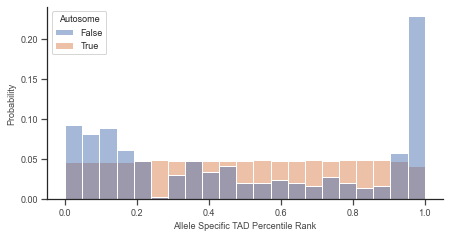

In [10]:
defaultPlotting()
allData['Autosome'] = allData['chrom'] != 'chrX'

fig, ax = plt.subplots()
sns.histplot(
    data=allData.loc[allData['cell']=='GM12878'], x='rank', hue='Autosome', stat='probability', 
    common_norm=False, ax=ax)
ax.set_xlabel('Allele Specific TAD Percentile Rank')
fig.savefig(f'{cell}-ASTAD-chrX-ranking.svg')

<AxesSubplot:xlabel='CNV', ylabel='z'>

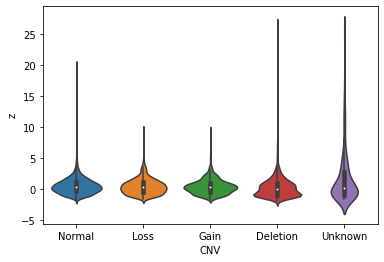

In [14]:
sns.violinplot(data=allData.loc[allData['cell']=='GM12878'], x='CNV', y='z')

In [13]:
allData.loc[allData['cell']=='GM12878'].groupby('CNV').size()

CNV
Deletion    1124
Gain         947
Loss        1492
Normal      4938
Unknown      293
dtype: int64